# Simulation Tools - Project 1

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import assimulo.problem as apro
import assimulo.solvers as asol


---------------------------------------------------------------------

## Task 1

#### Define pendulum function

In [13]:
def elastic_pendulum(t: float=0.0, x: float=[0.0, 0.0, 0.0, 0.0], k: float=1.0) -> np.ndarray:
    lmb = lambda y1, y2: (lambda d: k*(d - 1)/d if d != 0 else 0)(np.sqrt(y1**2 + y2**2))    # avoid division by zero -- just in case

    xvec = np.zeros_like(x)
    xvec[0] = x[2]
    xvec[1] = x[3]
    xvec[2] = -x[0] * lmb(x[0], x[1])
    xvec[3] = -x[1] * lmb(x[0], x[1]) - 1
    return xvec


#### Setup values

In [33]:
k = 1.0
t0, tfinal = 0.0, 10.0
y0 = np.array([1.0, 0.0, 0.0, 1.5])


#### Wrap as an Assimulo Explicit Problem

In [34]:
spring_problem = apro.Explicit_Problem(lambda t, y: elastic_pendulum(t, y, k=k), t0=t0, y0=y0)
spring_problem.name = r'Spring Pendulum with spring constant k={k}'
spring_problem.name = spring_problem.name.format(k=k)


#### CVode solver

In [35]:
spring_solver = asol.CVode(spring_problem)
spring_solver.reset()
# spring_solver.rtol = 1e-4
# spring_solver.atol = 1e-4
# spring_solver.discr = 'ADAMS'
# spring_solver.maxord = 8
t_sol, x_sol = spring_solver.simulate(100, 1000)


Final Run Statistics: Spring Pendulum with spring constant k=1.0 

 Number of steps                                 : 1444
 Number of function evaluations                  : 1786
 Number of Jacobian evaluations                  : 25
 Number of function eval. due to Jacobian eval.  : 100
 Number of error test failures                   : 69
 Number of nonlinear iterations                  : 1783
 Number of nonlinear convergence failures        : 0

Solver options:

 Solver                   : CVode
 Linear multistep method  : BDF
 Nonlinear solver         : Newton
 Linear solver type       : DENSE
 Maximal order            : 5
 Tolerances (absolute)    : 1e-06
 Tolerances (relative)    : 1e-06

Simulation interval    : 0.0 - 100.0 seconds.
Elapsed simulation time: 0.007005785999353975 seconds.


#### Plot the results

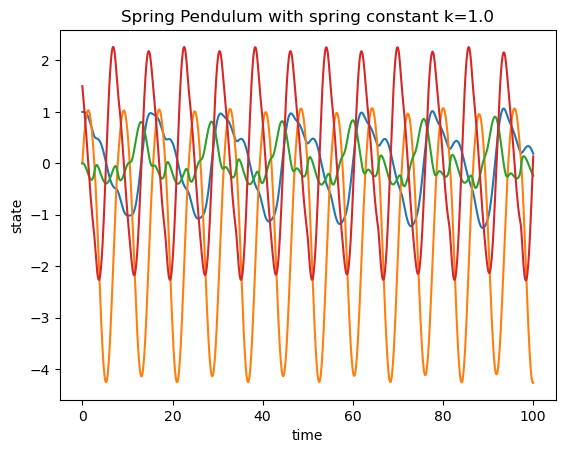

In [36]:
spring_solver.plot()


-------------------------------------------------------------------

## Task 2

#### Implement BDF4 solver using BDF2 template

In [ ]:
from assimulo.explicit_ode import Explicit_ODE
from assimulo.ode import *


In [ ]:
class BDF_2(Explicit_ODE):
    """
    BDF-2   (Example of how to set-up own integrators for Assimulo)
    """
    tol=1.e-8     
    maxit=100     
    maxsteps=500
    
    def __init__(self, problem):
        Explicit_ODE.__init__(self, problem) # Calls the base class
        
        #Solver options
        self.options["h"] = 0.01
        
        #Statistics
        self.statistics["nsteps"] = 0
        self.statistics["nfcns"] = 0
    
    def _set_h(self,h):
            self.options["h"] = float(h)

    def _get_h(self):
        return self.options["h"]
        
    h=property(_get_h,_set_h)
        
    def integrate(self, t, y, tf, opts):
        """
        _integrates (t,y) values until t > tf
        """
        h = self.options["h"]
        h = min(h, abs(tf-t))
        
        #Lists for storing the result
        tres = []
        yres = []
        
        for i in range(self.maxsteps):
            if t >= tf:
                break
            self.statistics["nsteps"] += 1
            
            if i==0:  # initial step
                t_np1,y_np1 = self.step_EE(t,y, h)
            else:   
                t_np1, y_np1 = self.step_BDF2([t,t_nm1], [y,y_nm1], h)
            t,t_nm1=t_np1,t
            y,y_nm1=y_np1,y
            
            tres.append(t)
            yres.append(y.copy())
        
            h=min(self.h,np.abs(tf-t))
        else:
            raise Explicit_ODE_Exception('Final time not reached within maximum number of steps')
        
        return ID_PY_OK, tres, yres
    
    def step_EE(self, t, y, h):
        """
        This calculates the next step in the integration with explicit Euler.
        """
        self.statistics["nfcns"] += 1
        
        f = self.problem.rhs
        return t + h, y + h*f(t, y) 
        
    def step_BDF2(self,T,Y, h):
        """
        BDF-2 with Fixed Point Iteration and Zero order predictor
        
        alpha_0*y_np1+alpha_1*y_n+alpha_2*y_nm1=h f(t_np1,y_np1)
        alpha=[3/2,-2,1/2]
        """
        alpha=[3./2.,-2.,1./2]
        f=self.problem.rhs
        
        t_n,t_nm1=T
        y_n,y_nm1=Y
        # predictor
        t_np1=t_n+h
        y_np1_i=y_n   # zero order predictor
        # corrector with fixed point iteration
        for i in range(self.maxit):
            self.statistics["nfcns"] += 1
            
            y_np1_ip1=(-(alpha[1]*y_n+alpha[2]*y_nm1)+h*f(t_np1,y_np1_i))/alpha[0]
            if SL.norm(y_np1_ip1-y_np1_i) < self.tol:
                return t_np1,y_np1_ip1
            y_np1_i=y_np1_ip1
        else:
            raise Explicit_ODE_Exception('Corrector could not converge within % iterations'%i)
            
    def print_statistics(self, verbose=NORMAL):
        self.log_message('Final Run Statistics            : {name} \n'.format(name=self.problem.name),        verbose)
        self.log_message(' Step-length                    : {stepsize} '.format(stepsize=self.options["h"]), verbose)
        self.log_message(' Number of Steps                : '+str(self.statistics["nsteps"]),          verbose)               
        self.log_message(' Number of Function Evaluations : '+str(self.statistics["nfcns"]),         verbose)
            
        self.log_message('\nSolver options:\n',                                    verbose)
        self.log_message(' Solver            : BDF2',                     verbose)
        self.log_message(' Solver type       : Fixed step\n',                      verbose)
